In [1]:
from plot import *
from fft import *
from maths import me, rmse, mse, mae, linear_interpolate, cosine_interpolate, cubic_interpolate
from maths import catmull_rom_interpolate, hermite_interpolate, fit_kochanek_bartels_spline

from fft import dft2_at_time_and_level, idft2_at_time_and_level


In [2]:
def plot_dft2_at_time_and_level(filename: str, variable: str, time: int, level: int, **kwargs):
    data = load_variable_at_time_and_level(filename, variable, time, level)

    fft = dft2_at_time_and_level(data, **kwargs)
    prediction, freqs = idft2_at_time_and_level(*fft)

    title = f"{format_variable(variable)} at {format_level(level)}" \
            f" on {format_date(filename)} at {format_time(time, filename)}"
    output = f"{variable}/{kwargs['quantile']}/{format_level(level, for_output=True)}" \
             f"-{format_date(filename, for_output=True)}-{format_time(time, filename)}"

    fig, ax1, ax2 = create_1x2_plot(title, sharey=True, sharex=True)
    ax1.imshow(data, cmap=cmr.arctic, origin="lower", extent=[-180, 180, -90, 90], aspect="auto")
    ax2.imshow(prediction, cmap=cmr.arctic, origin="lower", extent=[-180, 180, -90, 90], aspect="auto")

    ax1.grid(False)
    ax2.grid(False)

    ax1.xaxis.set_major_formatter(FormatStrFormatter("%d°"))
    ax1.yaxis.set_major_formatter(FormatStrFormatter("%d°"))

    fig.suptitle(title, fontsize=8, y=0.96)

    plt.savefig("assets/2D-dft-graphs/" + output + ".png", dpi=300)
    plt.show()

    title = f"Error ({get_units_from_variable(variable)}) at {format_level(level)} " \
            f" on {format_date(filename)} at {format_time(time, filename)}"

    fig, ax1, ax2 = create_1x2_plot(title, sharey=True, sharex=True)
    ax1.imshow(np.abs(prediction - data), cmap="hot", origin="lower", extent=[-180, 180, -90, 90], aspect="auto")
    ax2.imshow((prediction - data) ** 2, cmap="hot", origin="lower", extent=[-180, 180, -90, 90], aspect="auto")

    ax1.grid(False)
    ax2.grid(False)

    ax1.xaxis.set_major_formatter(FormatStrFormatter("%d°"))
    ax1.yaxis.set_major_formatter(FormatStrFormatter("%d°"))

    fig.suptitle(title, fontsize=8, y=0.96)
    ax1.set_title("Absolute Error (m/s)", fontsize=8)
    ax2.set_title("Squared Error (m²/s²)", fontsize=8)

    output += "-error"
    plt.savefig("assets/2D-dft-graphs/" + output + ".png", dpi=300)
    plt.show()

    lines = f"""
    Original Stdev: {data.astype('float32').std()} m/s
    Predicted ME:  {me(data, prediction)} m/s
    Predicted MAE:  {mae(data, prediction)} m/s
    Predicted RMSE: {rmse(data, prediction)} m/s

    Frequencies: {freqs}
    Size/time: {sum(el.nbytes for el in fft) * 36 / (1000 ** 2)} MB
    Size/day: {sum(el.nbytes for el in fft) * 36 * 8 / (1000 ** 2)} MB
    Size/year: {sum(el.nbytes for el in fft) * 36 * 8 * 365 / (1000 ** 2)} MB
    """
    print(lines)
    with open("assets/2D-dft-graphs/" + output + ".txt", "w") as file:
        file.writelines(lines)


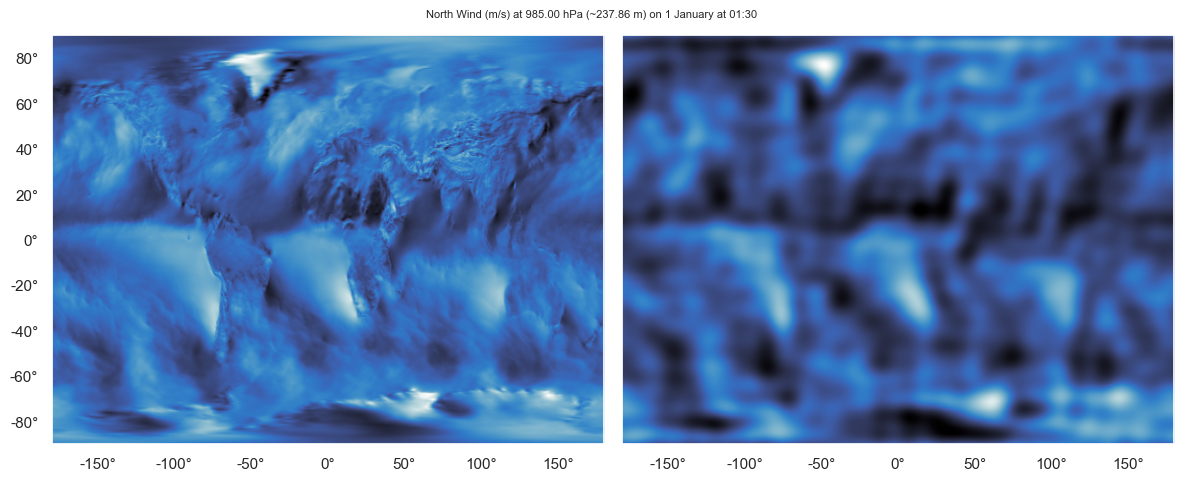

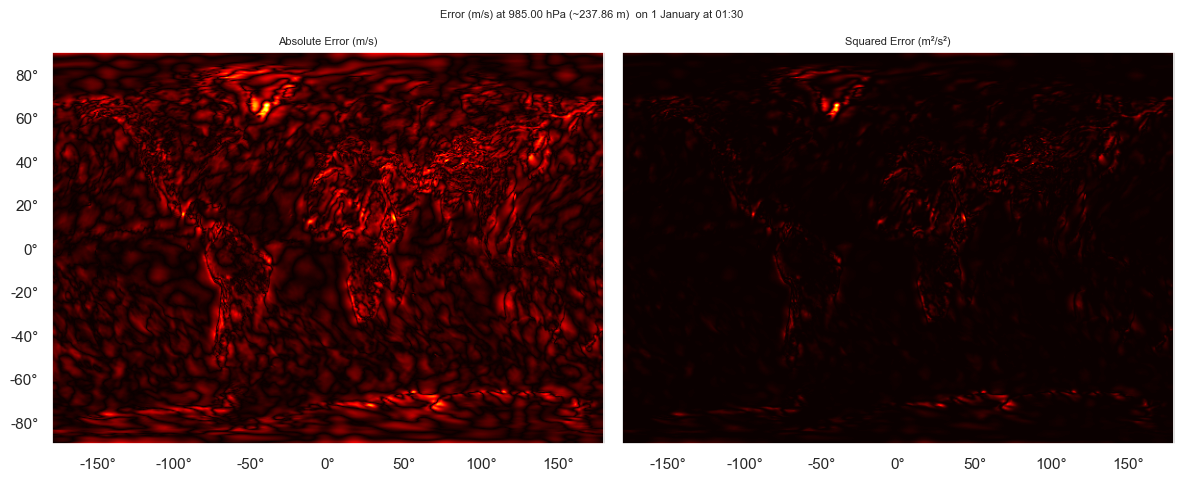


    Original Stdev: 2.9332211017608643 m/s
    Predicted ME:  -7.263908811114903e-05 m/s
    Predicted MAE:  0.8158391453609716 m/s
    Predicted RMSE: 1.1255311654302231 m/s

    Frequencies: 261
    Size/time: 0.043668 MB
    Size/day: 0.349344 MB
    Size/year: 127.51056 MB
    


In [4]:
for var in ["V"]:
    plot_dft2_at_time_and_level("MERRA2.tavg3_3d_asm_Nv.YAVG0101.nc4", var,
                                time=0, level=35, quantile=0.9975)


In [14]:
def fit_dft2_at_time(filename: str, variable: str, time: int, verbose: bool = True, **kwargs):
    data = load_variable_at_time(filename, variable, time)
    prediction = np.zeros((36, 361, 576), dtype="float32")
    frequencies = []

    dfts = []
    for lev in (tqdm(range(36)) if verbose else range(36)):
        fft = dft2_at_time_and_level(data[lev], **kwargs)
        dfts.append(fft)
        prediction[lev], freq = idft2_at_time_and_level(*fft)
        frequencies.append(freq)

    data = data.astype("float32")
    if verbose:
        size = sum(el.nbytes for dft in dfts for el in dft)
        lines = f"""
        Original Stdev: {data.std()} m/s
        Predicted MAE:  {mae(data, prediction)} m/s
        Predicted RMSE: {rmse(data, prediction)} m/s

        Frequencies: {sum(frequencies) / len(frequencies)}
        Size/time: {size / (1000 ** 2)} MB
        Size/day: {size * 8 / (1000 ** 2)} MB
        Size/year: {size * 8 * 365 / (1000 ** 2)} MB
        """
        print(lines)
    else:
        return data, prediction, dfts


def fit_dft2_on_day(filename: str, variable: str, **kwargs):
    data_variance = 0
    mae_error = 0
    mse_error = 0
    all_dfts = []

    for time in tqdm(range(8)):
        data, pred, dfts = fit_dft2_at_time(filename, variable, time, verbose=False, **kwargs)
        all_dfts.append(dfts)

        data_variance += data.var()
        mae_error += mae(data, pred)
        mse_error += mse(data, pred)

    size = sum(el.nbytes for dfts in all_dfts for dft in dfts for el in dft)
    lines = f"""
    Original Stdev: {(data_variance / 8) ** 0.5} m/s
    Predicted MAE:  {(mae_error / 8).mean()} m/s
    Predicted RMSE: {(mse_error / 8).mean() ** 0.5} m/s

    Size/day: {size / (1000 ** 2)} MB
    Size/year: {size * 365 / (1000 ** 2)} MB
    """
    print(lines)


def fit_interpolated_dft2_at_time(filename: str, variable: str, time: int, skip_levels: int = 2,
                                  interpolation: callable = linear_interpolate, verbose: bool = True,
                                  **kwargs):
    data = load_variable_at_time(filename, variable, time)
    prediction = np.zeros((36, 361, 576), dtype="float32")

    preds = []
    dfts = []
    levels = sorted(set(range(0, 36, skip_levels)).union({35}))
    for lev in (tqdm(levels) if verbose else levels):
        fft = dft2_at_time_and_level(data[lev], **kwargs)
        dfts.append(fft)
        preds.append(idft2_at_time_and_level(*fft)[0])

    for lev in range(36):
        if lev in levels:
            prediction[lev] = preds[levels.index(lev)]
            continue

        pred_idx = levels.index(lev - lev % skip_levels)
        t = (lev - levels[pred_idx]) / (levels[pred_idx + 1] - levels[pred_idx])
        prediction[lev] = interpolation(preds, pred_idx, t)

    data = data.astype("float32")
    if verbose:
        size = sum(el.nbytes for dft in dfts for el in dft)
        print(f"Original Stdev: {data.std()} m/s")
        print(f"Predicted RMSE: {rmse(data, prediction)} m/s")
        print(f"Predicted MAE:  {mae(data, prediction)} m/s")
        print(f"Size/time: {size / (1000 ** 2)} MB")
        print(f"Size/day: {size * 8 / (1000 ** 2)} MB")
        print(f"Size/year: {size * 8 * 365 / (1000 ** 2)} MB")
    else:
        return data, prediction, dfts


def fit_interpolated_dft2_on_day(filename: str, variable: str, quantile: float, skip_levels: int,
                                 interpolation: callable = linear_interpolate):
    data_variance = 0
    mae_error = np.zeros((36, 361, 576), dtype="float32")
    mse_error = np.zeros((36, 361, 576), dtype="float32")
    all_dfts = []

    for time in tqdm(range(8)):
        data, pred, dfts = fit_interpolated_dft2_at_time(filename, variable, time, skip_levels, interpolation,
                                                         quantile=quantile, verbose=False)
        all_dfts.append(dfts)

        data_variance += data.var()
        mae_error += abs(data - pred)
        mse_error += (data - pred) ** 2

    size = sum(el.nbytes for dfts in all_dfts for dft in dfts for el in dft)
    lines = f"""
    Original Stdev: {(data_variance / 8) ** 0.5} m/s
    Predicted MAE:  {(mae_error / 8).mean()} m/s
    Predicted RMSE: {(mse_error / 8).mean() ** 0.5} m/s

    Size/day: {size / (1000 ** 2)} MB
    Size/year: {size * 365 / (1000 ** 2)} MB
    """
    print(lines)


def fit_dft2_hermite_interpolated_at_time(filename: str, variable: str, time: int, quantile: float,
                                          levels: list[int], verbose: bool = True):
    data = load_variable_at_time(filename, variable, time)
    prediction = np.zeros((36, 361, 576), dtype="float32")

    preds = []
    dfts = []
    # levels = sorted(set(range(0, 36, skip_levels)).union({35}))
    for lev in (tqdm(levels) if verbose else levels):
        fft = dft2_at_time_and_level(data[lev], quantile=quantile)
        dfts.append(fft)
        preds.append(idft2_at_time_and_level(*fft)[0])

    tensions = []
    biases = []

    for lev in range(36):
        if lev in levels:
            continue

        pred_idx = -1
        for l in levels:
            if l < lev:
                pred_idx += 1

        t = (lev - levels[pred_idx]) / (levels[pred_idx + 1] - levels[pred_idx])

        best_tension, best_bias = fit_kochanek_bartels_spline(data[lev], preds, pred_idx, t)
        tensions.append(best_tension)
        biases.append(best_bias)

    tensions = np.array(tensions, dtype="float16")
    biases = np.array(biases, dtype="float16")

    for lev in range(36):
        if lev in levels:
            prediction[lev] = preds[levels.index(lev)]
            continue

        pred_idx = -1
        for l in levels:
            if l < lev:
                pred_idx += 1

        t = (lev - levels[pred_idx]) / (levels[pred_idx + 1] - levels[pred_idx])
        prediction[lev] = hermite_interpolate(preds, pred_idx, t, tensions[lev - pred_idx - 1], biases[lev - pred_idx - 1])

    data = data.astype("float32")
    if verbose:
        size = sum(el.nbytes for dft in dfts for el in dft)
        print(f"Original Stdev: {data.std()} m/s")
        print(f"Predicted RMSE: {rmse(data, prediction)} m/s")
        print(f"Predicted MAE:  {mae(data, prediction)} m/s")

        print(f"Size/time: {size / (1000 ** 2)} MB")
        print(f"Size/day: {size * 8 / (1000 ** 2)} MB")
        print(f"Size/year: {size * 8 * 365 / (1000 ** 2)} MB")
    else:
        return data, prediction, dfts, tensions, biases


def fit_dft2_hermite_interpolated_on_day(filename: str, variable: str, verbose: bool = True, **kwargs):
    data_variance = 0
    mae_error = 0
    mse_error = 0
    all_dfts = []

    last_pred = None
    next_pred = None

    for time in tqdm(range(8)):
        data, pred, dfts, tensions, biases = fit_dft2_hermite_interpolated_at_time(filename, variable, time, **kwargs, verbose=False)
        all_dfts.append(dfts)

        last_pred = next_pred
        next_pred = pred

        data_variance += data.var()
        mae_error += mae(data, pred)
        mse_error += mse(data, pred)

    if verbose:
        size = sum(el.nbytes for dfts in all_dfts for dft in dfts for el in dft) + (tensions.nbytes + biases.nbytes) * len(all_dfts)
        lines = f"""
        Original Stdev: {(data_variance / 8) ** 0.5} m/s
        Predicted MAE:  {(mae_error / 8)} m/s
        Predicted RMSE: {(mse_error / 8) ** 0.5} m/s

        Size/day: {size / (1000 ** 2)} MB
        Size/year: {size * 365 / (1000 ** 2)} MB
        """
        print(lines)
    else:
        return data_variance, mae_error, mse_error

In [7]:
fit_dft2_at_time("MERRA2.tavg3_3d_asm_Nv.YAVG0101.nc4", "U", time=0, quantile=0.991)

  0%|          | 0/36 [00:00<?, ?it/s]


        Original Stdev: 10.064826011657715 m/s
        Predicted MAE:  0.37481167912483215 m/s
        Predicted RMSE: 0.5430525022173176 m/s

        Frequencies: 939.0555555555555
        Size/time: 0.144269 MB
        Size/day: 1.154152 MB
        Size/year: 421.26548 MB
        


In [17]:
fit_dft2_on_day("MERRA2.tavg3_3d_asm_Nv.YAVG0101.nc4", "U", quantile=0.991)


  0%|          | 0/8 [00:00<?, ?it/s]


    Original Stdev: 10.1023820749644 m/s
    Predicted MAE:  0.37089501321315765 m/s
    Predicted RMSE: 0.5364013270455839 m/s

    Size/day: 1.153647 MB
    Size/year: 421.081155 MB
    


In [19]:
fit_dft2_hermite_interpolated_on_day("MERRA2.tavg3_3d_asm_Nv.YAVG0101.nc4", "U", quantile=0.991,
                                     levels=range(36))


  0%|          | 0/8 [00:00<?, ?it/s]


        Original Stdev: 10.1023820749644 m/s
        Predicted MAE:  0.3708951473236084 m/s
        Predicted RMSE: 0.5364013721878769 m/s

        Size/day: 1.153647 MB
        Size/year: 421.081155 MB
        


In [99]:
fit_dft2_hermite_interpolated_on_day("MERRA2.tavg3_3d_asm_Nv.YAVG0101.nc4", "U", quantile=0.985,
                                     levels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 15, 18, 23, 30, 32, 34, 35])


  0%|          | 0/8 [00:00<?, ?it/s]


        Original Stdev: 10.1023820749644 m/s
        Predicted MAE:  0.32676925882697105 m/s
        Predicted RMSE: 0.47057024081183085 m/s

        Size/day: 0.586263 MB
        Size/year: 213.985995 MB
        
